<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019/blob/homework/10-CV/HW/hw3/cv_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [*CV HW3*](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/homework/10-CV/HW/hw3/Homework%20Detections.ipynb)

[Georgia Tech face database](http://www.anefian.com/research/face_reco.htm)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os, glob, pickle, re
import cv2
import numpy as np

from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
tf.__version__

'2.0.0'

In [3]:
tf.test.is_gpu_available(), 'COLAB_TPU_ADDR' in os.environ

(True, False)

In [0]:
from tensorflow.keras.applications.vgg16 import (
    VGG16,
    preprocess_input as vgg16_preprocess_input
)
from tensorflow.keras.models import load_model

## *Загрузка данных*

In [0]:
%%bash

test -d gt_db || {
    wget -q -O labels_gt.zip http://www.anefian.com/research/labels_gt.zip
    wget -q -O gt_db.zip http://www.anefian.com/research/gt_db.zip

    unzip -oq labels_gt.zip
    unzip -oq gt_db.zip
    rm gt_db/s33/pspbrwse.jbf
    test -e models || mkdir -p models
}

In [0]:
image_paths = sorted(glob.glob('gt_db/*/*'))
label_paths = sorted(glob.glob('labels/*'))

In [7]:
len(image_paths), len(label_paths)

(750, 750)

Загрузка координат рамок:

In [8]:
true_boxes = np.zeros((len(label_paths), 4)).astype(np.int)

for i, label_path in enumerate(label_paths):
    with open(label_path) as label_file:
        true_boxes[i] = np.array(label_file.readline().split()[:-1]).astype(np.int)
        
true_boxes.shape

(750, 4)

Изображений не так много, поэтому просто загрузим их в память:

In [0]:
images = np.array([ cv2.imread(path, cv2.IMREAD_COLOR) for path in image_paths ])

Визуализация:

In [0]:
def show_image_with_bounding_boxes(image, boxes, colors):
    img = np.copy(image)
    for i, box in enumerate(boxes):
        xA, yA, xB, yB = box[:4]
        cv2.rectangle(img, (xA, yA), (xB, yB), colors[i], thickness=2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.grid(False)
    plt.title('{}x{}'.format(*img.shape))

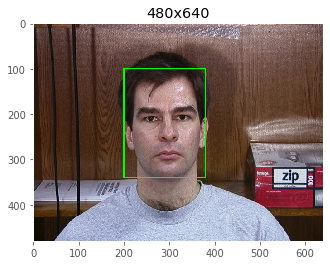

In [11]:
show_image_with_bounding_boxes(images[0], [ true_boxes[0] ], [ (0, 255, 0) ])

Размер изображений:

In [12]:
IMG_HEIGHT, IMG_WIDTH = images[0].shape[:2]

IMG_HEIGHT, IMG_WIDTH

(480, 640)

### Распределение размеров разметки

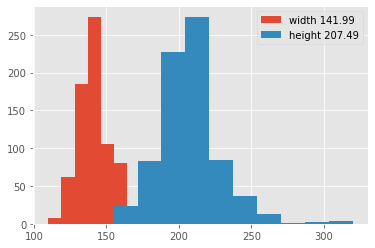

In [13]:
widths, heights = zip(*[ (xB - xA, yB - yA) for xA, yA, xB, yB in true_boxes ])

plt.hist(widths, label=f'width {np.mean(widths):.2f}')
plt.hist(heights, label=f'height {np.mean(heights):.2f}')
plt.legend();

## *Базовая модель*

In [14]:
features = VGG16(include_top=False,
                 weights='imagenet',
                 input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

feature_tensor = features.layers[-1].output

for layer in features.layers[:-4]:
    layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [15]:
feature_tensor.shape

TensorShape([None, 15, 20, 512])

## *Anchor grid*

In [16]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 140.
ANCHOR_HEIGHT = 210. 

ANCHOR_CENTERS = np.mgrid[GRID_STEP_H / 2 : IMG_HEIGHT: GRID_STEP_H,
                          GRID_STEP_W / 2 : IMG_WIDTH : GRID_STEP_W,]

FEATURE_SHAPE, ANCHOR_CENTERS.shape

((15, 20), (2, 15, 20))

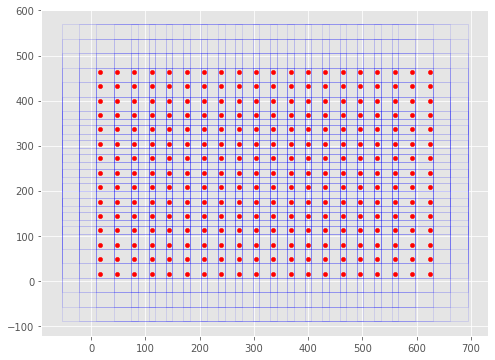

In [17]:
def make_anchor_rect(center, w=ANCHOR_WIDTH, h=ANCHOR_HEIGHT):
    return np.array([
        [center[0] - w / 2, center[1] - h / 2],
        [center[0] - w / 2, center[1] + h / 2],
        [center[0] + w / 2, center[1] + h / 2],
        [center[0] + w / 2, center[1] - h / 2],
        [center[0] - w / 2, center[1] - h / 2],
    ])

anchor_centers_y, anchor_centers_x = ANCHOR_CENTERS.reshape(-1, *FEATURE_SHAPE[::-1]).reshape(2, -1)

plt.figure(figsize=(8, 6))
plt.scatter(anchor_centers_x,
            anchor_centers_y,
            c='r', s=18)

for cx, cy in zip(anchor_centers_x, anchor_centers_y):
    vertices = make_anchor_rect((cx, cy))
    plt.plot(vertices[:, 0], vertices[:, 1],
             c='b', alpha=0.1, lw=1)

### Кодировка ground truth

Будем работать в размере исходных изображений (они одинаковые, $640\times480$), поэтому переменные `x_scale`, `y_scale` из исходной версии функций не используются и здесь удалены.

In [0]:
def iou(box, anchor_x, anchor_y, anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):

    rect_x1, rect_y1, rect_x2, rect_y2 = box

    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2

    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))

    intersection = dx * dy if (dx > 0 and dy > 0) else 0.

    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection

    return intersection / union

In [0]:
def encode_anchors(true_box, iou_thr=0.5):
    xA, yA, xB, yB = true_box
    encoded = np.zeros(shape=(FEATURE_SHAPE[0], FEATURE_SHAPE[1], 5), dtype=np.float32)
    scores = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            anchor_x = ANCHOR_CENTERS[1, row, col]
            anchor_y = ANCHOR_CENTERS[0, row, col]
            score = iou(true_box, anchor_x, anchor_y)
            scores.append((score, anchor_x, anchor_y, row, col))

    scores = sorted(scores, reverse=True)

    if scores[0][0] < iou_thr:
        scores = [s for s in scores if s[0] == scores[0][0]]  # default anchor
    else:
        scores = [e for e in scores if e[0] > iou_thr]

    true_box_w, true_box_h = xB - xA, yB - yA
    true_box_cx, true_box_cy = xA + true_box_w / 2, yA + true_box_h / 2
    
    for score, anchor_x, anchor_y, row, col in scores:
        dx = (anchor_x - true_box_cx) / ANCHOR_WIDTH
        dy = (anchor_y - true_box_cy) / ANCHOR_HEIGHT
        dw = (ANCHOR_WIDTH - true_box_w) / ANCHOR_WIDTH
        dh = (ANCHOR_HEIGHT - true_box_h) / ANCHOR_HEIGHT
        encoded[row, col] = [1., dx, dy, dw, dh]

    return encoded

### Декодировка

In [0]:
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(logit)
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                
                cx = anchor_x - dx * ANCHOR_WIDTH
                cy = anchor_y - dy * ANCHOR_HEIGHT
                w = ANCHOR_WIDTH - dw * ANCHOR_WIDTH
                h = ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT
                
                xA = cx - w / 2
                yA = cy - h / 2
                xB = cx + w / 2
                yB = cy + h / 2
                            
                rectangles.append(np.round(np.array([xA, yA, xB, yB])).astype(np.int).tolist() + [conf])

    return rectangles

### Валидация энкодинга/декодинга

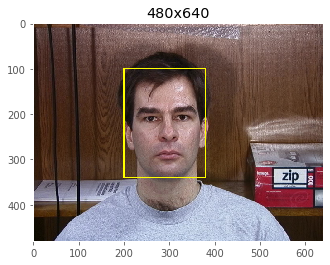

In [21]:
encoded = encode_anchors(true_boxes[0])

decoded = decode_prediction(encoded, conf_thr=0.5)
decoded = sorted(decoded, key = lambda e: -e[-1])

show_image_with_bounding_boxes(images[0], [ true_boxes[0] ] + decoded,
                               [ (0, 255, 0) ] + len(decoded) * [ (0, 255, 255) ])

## *Функция потерь*

In [0]:
K = keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0], 
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]
    
    # TODO: добавьте функцию потерь для классификации детекции
    
    y_true = K.reshape(y_true, (batch_size, -1, 5))
    y_pred = K.reshape(y_pred, (batch_size, -1, 5))

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    return total_conf_loss + 0.5 * loc_loss

## *Генератор для обучения модели*

*TODO*: аугментации

In [0]:
class DatasetGenerator(tf.keras.utils.Sequence):

    def __init__(self, images, true_boxes, batch_size, shuffle=True):
        self.images = images
        self.true_boxes = true_boxes
        self.batch_size = batch_size
        self.n_samples = len(images)
        self.shuffle = shuffle
        self.ix = np.arange(len(images))
        if shuffle:
            self.on_epoch_end()

    def __len__(self):
        return (self.n_samples // self.batch_size) + (0 < self.n_samples % self.batch_size)

    def __getitem__(self, batch_ix):
        batch_offs = batch_ix * self.batch_size
        batch_size = np.min([self.batch_size, self.n_samples - batch_offs])
        ix = self.ix[batch_offs:batch_offs + batch_size]
        batch_images = np.array(
            [ vgg16_preprocess_input(img.astype(np.float32)) for img in self.images[ix] ]
        )
        targets = np.array(
            [ encode_anchors(true_box) for true_box in self.true_boxes[ix] ]
        )
        return batch_images, targets

    def on_epoch_end(self):
        if self.shuffle:
            self.ix = np.random.permutation(self.n_samples)

## *Добавляем выход детектора*

In [24]:
output = keras.layers.BatchNormalization()(feature_tensor)

output = keras.layers.Conv2D(5,
                             kernel_size=(1, 1), 
                             activation='linear',
                             kernel_regularizer='l2',
                             name='output')(output)

model = keras.models.Model(inputs=features.inputs, outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 480, 640, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 480, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 480, 640, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 240, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 240, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 240, 320, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 120, 160, 128)     0     

## *Обучение*

In [0]:
BATCH_SIZE = 10
SAVE_PATH = 'models'
FORCE_TRAIN = False or (0 >= len(glob.glob(os.path.join(SAVE_PATH, '*.hdf5'))))

hist_path = os.path.join(SAVE_PATH, 'train.hitsory')

In [0]:
adam = keras.optimizers.Adam(lr=3e-4, decay=1e-6)
model.compile(optimizer=adam, 
              loss=total_loss,
              metrics={'output': confidence_loss})

In [0]:
checkpoint = keras.callbacks.ModelCheckpoint(
    os.path.join(SAVE_PATH, 'cv_hw3.{epoch:02d}-{val_loss:.3f}.hdf5'),
    monitor='val_loss',
    verbose=1,  
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    save_freq='epoch')

earlyStopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    min_delta=0.001,
    verbose=1)

Разделение выборки на обучение / тест:

In [0]:
train_ix, test_ix = train_test_split(np.random.permutation(len(image_paths)),
                                     test_size=1./15,
                                     random_state=808)

Обучение:

In [29]:
if FORCE_TRAIN:
    !ls -1 {SAVE_PATH}/ | xargs -r -I%% rm {SAVE_PATH}/%%
    
    history = model.fit_generator(
        generator=DatasetGenerator(images[train_ix], true_boxes[train_ix], BATCH_SIZE),
        validation_data=DatasetGenerator(images[test_ix], true_boxes[test_ix], BATCH_SIZE, False),
        epochs=10000,
        callbacks=[checkpoint, earlyStopping],
        workers=-1,
        verbose=1,
        shuffle=False)

    with open(hist_path, 'wb') as hist_dump:
        pickle.dump(history.history, hist_dump)

Epoch 1/10000
69/70 [============================>.] - ETA: 2s - loss: 1.0272 - confidence_loss: 0.6585
Epoch 00001: val_loss improved from inf to 1.12122, saving model to models/cv_hw3.01-1.121.hdf5
70/70 [==============================] - 148s 2s/step - loss: 1.0227 - confidence_loss: 0.6565 - val_loss: 1.1212 - val_confidence_loss: 0.5856
Epoch 2/10000
69/70 [============================>.] - ETA: 1s - loss: 0.6494 - confidence_loss: 0.4563
Epoch 00002: val_loss improved from 1.12122 to 0.67244, saving model to models/cv_hw3.02-0.672.hdf5
70/70 [==============================] - 140s 2s/step - loss: 0.6487 - confidence_loss: 0.4554 - val_loss: 0.6724 - val_confidence_loss: 0.4374
Epoch 3/10000
69/70 [============================>.] - ETA: 1s - loss: 0.5449 - confidence_loss: 0.3523
Epoch 00003: val_loss improved from 0.67244 to 0.58634, saving model to models/cv_hw3.03-0.586.hdf5
70/70 [==============================] - 139s 2s/step - loss: 0.5442 - confidence_loss: 0.3517 - val_los

Загружаем сохранённую модель с наименьшим лоссом.

In [30]:
model_files = glob.glob('models/*.hdf5')

loss = np.array(
    [float(re.search(r'^.*cv_hw3\.\d{2}-(.*)\.hdf5$', m)[1]) for m in model_files]
)

best_model = model_files[np.argmin(loss)]

best_model

'models/cv_hw3.12-0.193.hdf5'

In [0]:
model = load_model(
    best_model,
    custom_objects={
        'total_loss': total_loss,
        'confidence_loss': confidence_loss
        }
    )

## *Детекция*

In [0]:
def predict(model, images):
    return model.predict(
        vgg16_preprocess_input(np.array(images).astype(np.float32))
    )

def show_predictions(image, true_box, pred, num_pred_boxes=3):
    decoded = decode_prediction(pred, conf_thr=0.)
    decoded = sorted(decoded, key=lambda e: -e[-1])[:num_pred_boxes]
    show_image_with_bounding_boxes(
        image,
        [ true_box ] + decoded,
        [ (0, 255, 0) ] + len(decoded) * [ (0, 0, 255) ]
    )
    return decoded

Визуализируем результат детекции на нашем тестовом изображении:

[[209, 130, 348, 337, 0.9132847200246045],
 [232, 122, 373, 330, 0.9037510944666906],
 [228, 119, 370, 327, 0.8909232356606857]]

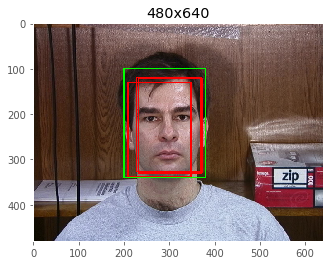

In [33]:
show_predictions(images[0], true_boxes[0], predict(model, [images[0]])[0])

Визуализируем ещё 5 случайных изображений из тестовой выборки.

In [0]:
sample_ix = np.random.choice(test_ix, 5, replace=False)
preds = predict(model, images[sample_ix])

[[230, 132, 366, 334, 0.989391282115904],
 [236, 139, 373, 343, 0.9858481587555453],
 [248, 133, 387, 336, 0.9661317960756383]]

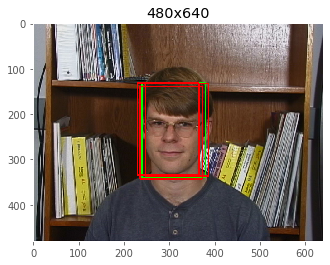

In [35]:
show_predictions(images[sample_ix[0]], true_boxes[sample_ix[0]], preds[0])

[[199, 137, 338, 343, 0.9781814953821584],
 [202, 137, 341, 343, 0.9768561914631244],
 [206, 123, 345, 329, 0.9699780496654657]]

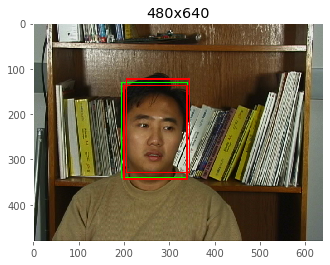

In [36]:
show_predictions(images[sample_ix[1]], true_boxes[sample_ix[1]], preds[1])

[[200, 139, 338, 343, 0.984575433489972],
 [196, 133, 335, 337, 0.980836611375908],
 [180, 133, 319, 340, 0.9679438882761531]]

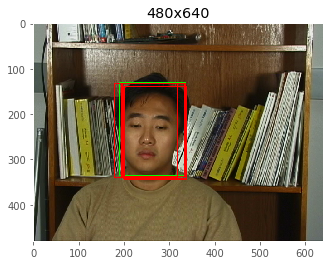

In [37]:
show_predictions(images[sample_ix[2]], true_boxes[sample_ix[2]], preds[2])

[[204, 76, 343, 282, 0.9818088342535917],
 [195, 80, 333, 285, 0.981359444711953],
 [212, 66, 351, 273, 0.9314546648545164]]

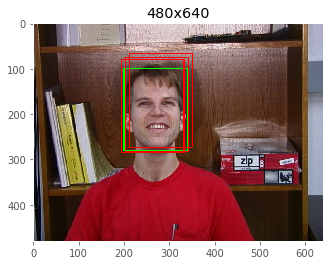

In [38]:
show_predictions(images[sample_ix[3]], true_boxes[sample_ix[3]], preds[3])

[[204, 153, 343, 359, 0.9661957082331548],
 [221, 173, 360, 377, 0.9654663590583054],
 [204, 154, 343, 360, 0.9621872332704829]]

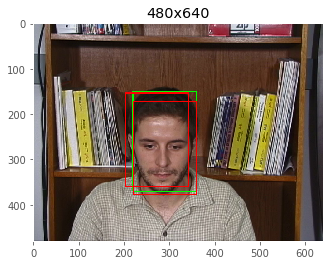

In [39]:
show_predictions(images[sample_ix[4]], true_boxes[sample_ix[4]], preds[4])

## Метрики качества

*TODO*